<a href="https://colab.research.google.com/github/whegedusich/SuperBowlWinFactors/blob/main/nfl_sb_probs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thanks to Robert Clark for the sportsipy API (https://github.com/roclark/sportsipy/blob/ea0043747015209550abeee15df75914a58fe40b/docs/index.rst). Made all the difference and significantly reduced what I thought would be a massive data mining effort. 

In [ ]:
# Import packages
!pip install sportsipy
import sportsipy
from sportsipy.nfl.teams import Teams
import pandas as pd

Load in the data. We are only looking back to 2002 since that is when the 16-game regular season last began. Prior to that, season lengths were imbalanced due to differences in the number of teams in divisions.

In [41]:
# 16-game season only goes back consistently to 2002
years = range(2002, 2020, 1)

# Read in relevant data for all teams for every year from 2002 to 2019
info = [[year, team.name, team.abbreviation, team.wins, team.losses, team.win_percentage, team.strength_of_schedule, team.post_season_result] for year in years for team in Teams(year)]

# Put data into DataFrame
data = pd.DataFrame(columns=['Year', 'Team', 'Abbv', 'Wins', 'Losses',
                             'Win_Ratio', 'Schedule Strength', 'Postseason'],
                    data=info)
  
data.head()

,Year,Team,Abbv,Wins,Losses,Win_Ratio,Schedule Strength,Postseason
0,2002,Kansas City Chiefs,KAN,8,8,0.500,1.9,None
1,2002,Oakland Raiders,RAI,11,5,0.688,1.5,Lost Conference Championship
2,2002,New Orleans Saints,NOR,9,7,0.563,-0.3,None
3,2002,Philadelphia Eagles,PHI,12,4,0.750,-2.6,Lost Conference Championship
4,2002,Atlanta Falcons,ATL,9,6,0.594,-0.4,Lost Divisional


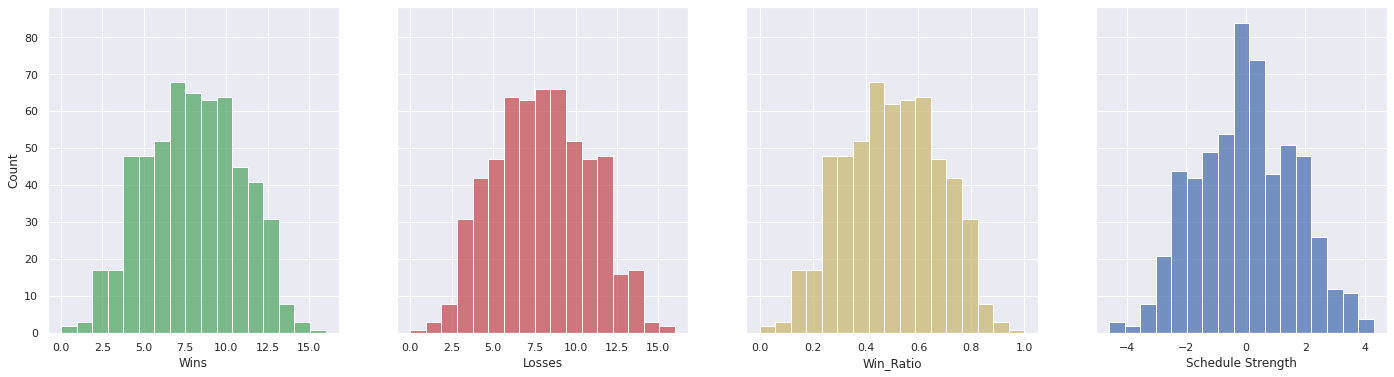

In [42]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

fig, axes = plt.subplots(1,4, figsize=(24,6), sharey=True)

sns.histplot(data['Wins'], color='g', ax=axes[0])
sns.histplot(data['Losses'], color='r', ax=axes[1])
sns.histplot(data['Win_Ratio'], color='y', ax=axes[2])
sns.histplot(data['Schedule Strength'], ax=axes[3])

Now we will add columns for a team's wins and losses for the previous year. This would allow us to look at a team's previous year's performance and the upcoming schedule's difficulty and make predictions about their performance.

In [39]:
"""
First we need to to iterate over the unique teams in the dataframe and break
each team into it's own dataframe to shift their data by a year. This is to 
prevent the most recent data from one team from being shifted into the oldest 
data for a different team (for example).
"""

# Isolate each team into a separate dataframe based on abbreviation
team_dfs = [data[data['Abbv'] == abbv].copy() for abbv in data['Abbv'].unique()]

# Sort each team's dataframe by year
team_dfs = [df.sort_values(by='Year', ascending=False) for df in team_dfs]

# Iterate over dataframes for each team, and shift relevant columns back a year
for team in team_dfs:
  team['Prev_Wins'] = team['Wins'].copy().shift(-1)
  team['Prev_Losses'] = team['Losses'].copy().shift(-1)
  team['Prev_Win_Ratio'] = team['Win_Ratio'].copy().shift(-1)
  team['Prev_Sch_Str'] = team['Schedule Strength'].copy().shift(-1)
  team['Prev Postseason'] = team['Postseason'].copy().shift(-1)

data = pd.concat(team_dfs)

data.sample(n=10)

,Year,Team,Abbv,Wins,Losses,Win_Ratio,Schedule Strength,Postseason,Prev_Wins,Prev_Losses,Prev_Win_Ratio,Prev_Sch_Str,Prev Postseason
362,2013,San Francisco 49ers,SFO,12,4,0.750,1.8,Lost Conference Championship,11.0,4.0,0.719,2.5,Lost Super Bowl
299,2011,Baltimore Ravens,RAV,12,4,0.750,-0.9,Lost Conference Championship,12.0,4.0,0.750,1.0,Lost Divisional
132,2006,New Orleans Saints,NOR,10,6,0.625,-1.6,Lost Conference Championship,3.0,13.0,0.188,-0.9,None
375,2013,Oakland Raiders,RAI,4,12,0.250,0.2,None,4.0,12.0,0.250,-1.3,None
177,2007,Washington Redskins,WAS,9,7,0.563,3.0,Lost WC,5.0,11.0,0.313,0.3,None
298,2011,San Francisco 49ers,SFO,13,3,0.813,-1.1,Lost Conference Championship,6.0,10.0,0.375,-3.3,None
54,2003,New York Jets,NYJ,6,10,0.375,0.4,None,9.0,7.0,0.563,1.7,Lost Divisional
185,2007,Miami Dolphins,MIA,1,15,0.063,2.3,None,6.0,10.0,0.375,2.1,None
178,2007,Tampa Bay Buccaneers,TAM,9,7,0.563,-2.8,Lost WC,4.0,12.0,0.250,0.9,None
283,2010,Buffalo Bills,BUF,4,12,0.250,4.3,None,6.0,10.0,0.375,2.4,None


In [43]:
# Create dummies from postseason result column
data = pd.get_dummies(data, columns=['Postseason'], drop_first=True)

# Drop Lost SB column since this leaks info about the target column
data.drop(columns='Postseason_Lost Super Bowl', inplace=True)

In [45]:
from sklearn.utils import resample

minority = data[data['Postseason_Won Super Bowl'] == 1]
majority = data[data['Postseason_Won Super Bowl'] == 0]

# Resample minority class for better balance
min_upsampled = resample(minority,
                         replace=True,
                         n_samples = len(majority),
                         random_state=42)

data_balanced = pd.concat([min_upsampled, majority])

use_cols = ['Win_Ratio', 'Schedule Strength']

model_data = data_balanced[use_cols]

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

x_train, x_test, y_train, y_test = train_test_split(model_data, data_balanced['Postseason_Won Super Bowl'], test_size=0.3, random_state=42)

x_train = ss.fit_transform(x_train)

x_test = ss.transform(x_test)

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

logreg = LogisticRegression(random_state=42)

logreg.fit(x_train, y_train)
preds = logreg.predict(x_test)
probs = logreg.predict_proba(x_test)

logreg.score(x_test, y_test)

0.8363095238095238

In [53]:
samp = data[use_cols].copy()

samp = ss.transform(samp)
samp = pd.DataFrame(samp)

preds = logreg.predict_proba(samp)

data[['Loss Prob', 'Win Prob']] = preds

data.sort_values(by='Win Prob', ascending=False)

,Year,Team,Abbv,Wins,Losses,Win_Ratio,Schedule Strength,Postseason_Lost Divisional,Postseason_Lost WC,Postseason_Won Super Bowl,Loss Prob,Win Prob
160,2007,New England Patriots,NWE,16,0,1.000,0.4,0,0,0,0.011292,0.988708
74,2004,Pittsburgh Steelers,PIT,15,1,0.938,1.4,0,0,0,0.015133,0.984867
256,2010,New England Patriots,NWE,14,2,0.875,2.6,1,0,0,0.018683,0.981317
67,2004,New England Patriots,NWE,14,2,0.875,1.8,0,0,1,0.027057,0.972943
102,2005,Denver Broncos,DEN,13,3,0.813,2.2,0,0,0,0.047355,0.952645
...,...,...,...,...,...,...,...,...,...,...,...,...
443,2015,Tennessee Titans,OTI,3,13,0.188,-2.8,0,0,0,0.999201,0.000799
412,2014,Tampa Bay Buccaneers,TAM,2,14,0.125,-1.5,0,0,0,0.999324,0.000676
93,2004,San Francisco 49ers,SFO,2,14,0.125,-1.6,0,0,0,0.999355,0.000645
255,2009,St. Louis Rams,RAM,1,15,0.063,-1.1,0,0,0,0.999622,0.000378


In [56]:
data[data['Postseason_Won Super Bowl'] == 1].sort_values(by='Win Prob', ascending=False)

,Year,Team,Abbv,Wins,Losses,Win_Ratio,Schedule Strength,Postseason_Lost Divisional,Postseason_Lost WC,Postseason_Won Super Bowl,Loss Prob,Win Prob
67,2004,New England Patriots,NWE,14,2,0.875,1.8,0,0,1,0.027057,0.972943
43,2003,New England Patriots,NWE,14,2,0.875,0.1,0,0,1,0.058566,0.941434
360,2013,Seattle Seahawks,SEA,13,3,0.813,1.4,0,0,1,0.067693,0.932307
434,2015,Denver Broncos,DEN,12,4,0.750,2.1,0,0,1,0.102337,0.897663
211,2008,Pittsburgh Steelers,PIT,12,4,0.750,2.0,0,0,1,0.106771,0.893229
224,2009,New Orleans Saints,NOR,13,3,0.813,0.2,0,0,1,0.113614,0.886386
130,2006,Indianapolis Colts,CLT,12,4,0.750,1.7,0,0,1,0.121098,0.878902
387,2014,New England Patriots,NWE,12,4,0.750,1.3,0,0,1,0.142750,0.857250
482,2017,Philadelphia Eagles,PHI,13,3,0.813,-0.7,0,0,1,0.164092,0.835908
450,2016,New England Patriots,NWE,14,2,0.875,-2.7,0,0,1,0.189827,0.810173
